# Price Prediction Of Diamonds

In [45]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn import metrics


# Data Loading

In [46]:
data = pd.read_csv("diamonds.csv")
data.head(7)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
5,6,0.24,Very Good,J,VVS2,62.8,57.0,336,3.94,3.96,2.48
6,7,0.24,Very Good,I,VVS1,62.3,57.0,336,3.95,3.98,2.47


## Data Preprocessing


### Data cleaning

In [47]:
data = data.drop(["Unnamed: 0"], axis=1)
data.describe()


,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [48]:
#Dropping dimentionless diamonds
data = data.drop(data[data["x"]==0].index)
data = data.drop(data[data["y"]==0].index)
data = data.drop(data[data["z"]==0].index)
#We lost 20 data points by deleting the dimensionless(2-D or 1-D) diamonds.
data.shape


(53920, 10)

### data visualistion and understanding

In [ ]:
ax = sns.regplot(x="price", y="y", data=data, fit_reg=True, scatter_kws={"color": "#a9a799"}, line_kws={"color": "#835656"})
ax.set_title("Regression Line on Price vs 'y'", color="#4e4c39")

In [ ]:
ax1= sns.regplot(x="price", y="z", data=data, fit_reg=True, scatter_kws={"color": "#a9a799"}, line_kws={"color": "#835656"})
ax1.set_title("Regression Line on Price vs 'z'", color="#4e4c39")

Text(0.5, 1.0, 'Regression Line on Price vs Depth')

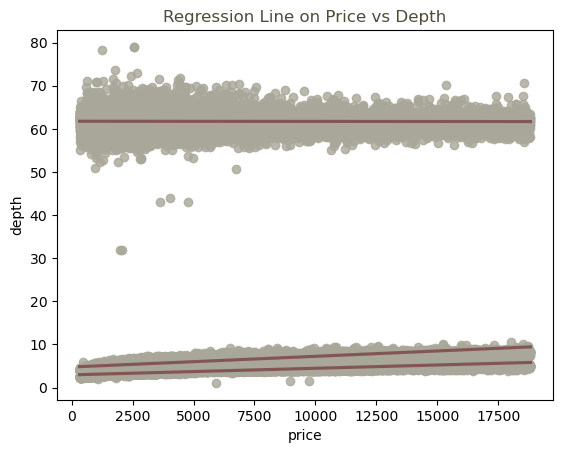

In [49]:
ax2= sns.regplot(x="price", y="depth", data=data, fit_reg=True, scatter_kws={"color": "#a9a799"}, line_kws={"color": "#835656"})
ax2.set_title("Regression Line on Price vs Depth", color="#4e4c39")


### Removing outliers

/Users/wassef/anaconda3/envs/AI-Class/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


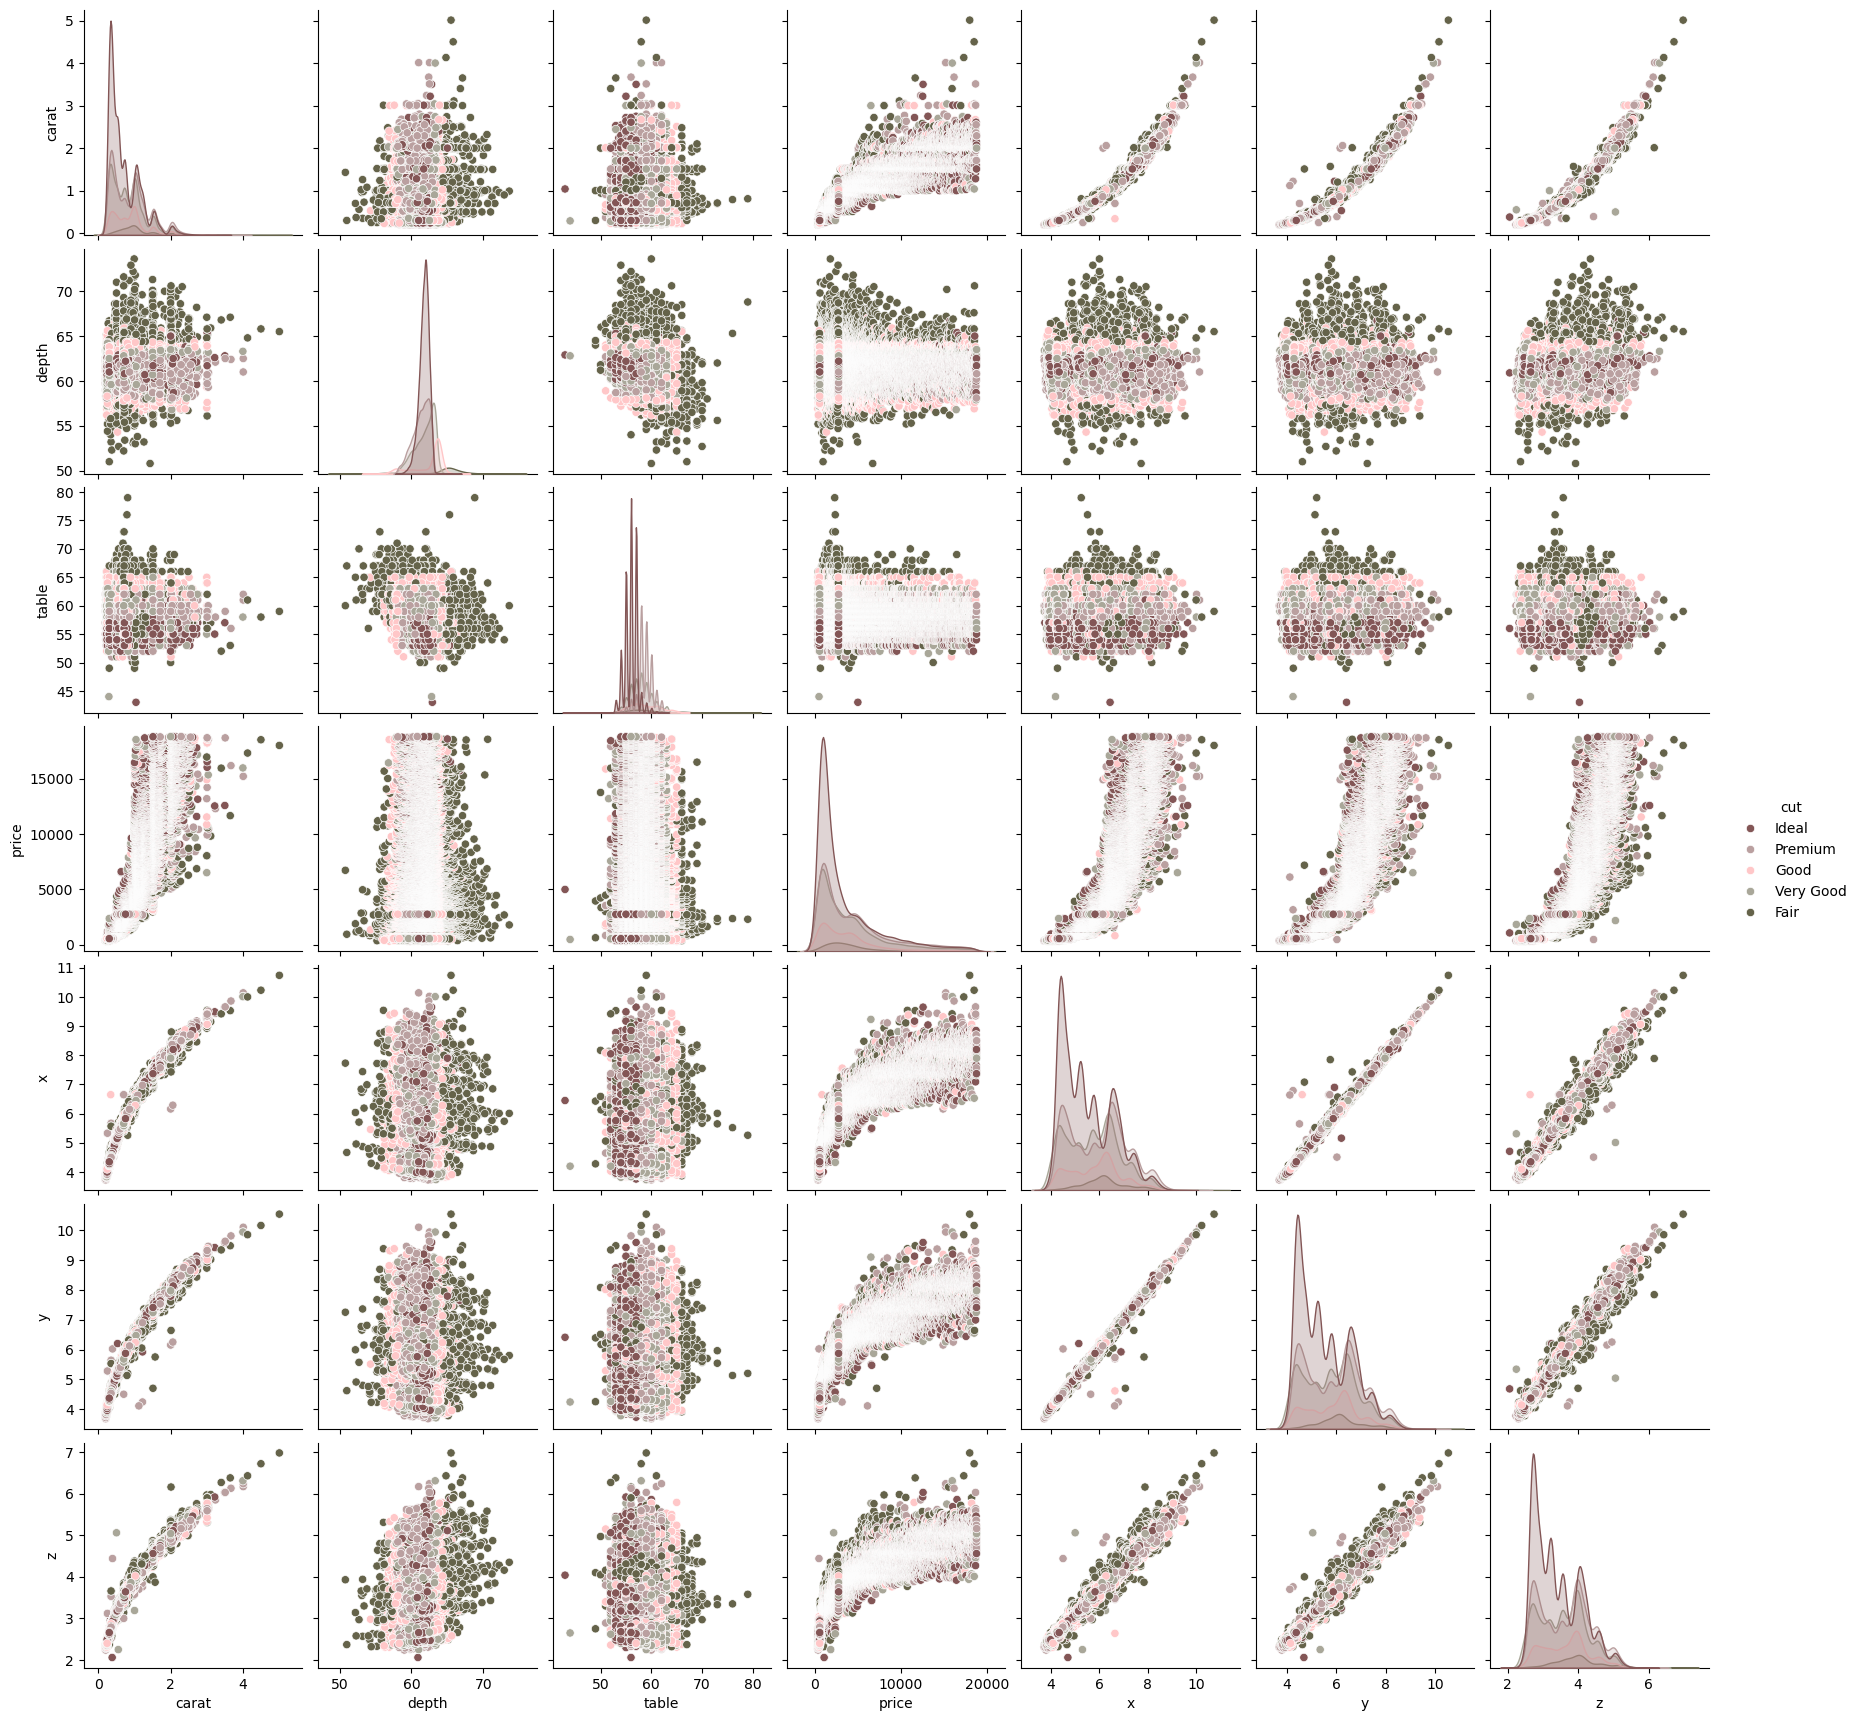

In [27]:
data = data[(data["depth"]<75)&(data["depth"]>45)]
data = data[(data["table"]<80)&(data["table"]>40)]
data = data[(data["x"]<30)]
data = data[(data["y"]<30)]
data = data[(data["z"]<30)&(data["z"]>2)]
data.shape

ax=sns.pairplot(data, hue= "cut",palette=shade)

### Data Encoding

In [29]:
# Get list of categorical variables
s = (data.dtypes =="object")
object_cols = list(s[s].index)
print("Categorical variables:")
print(object_cols)

Categorical variables:
['cut', 'color', 'clarity']


In [30]:
# Make copy to avoid changing original data 
label_data = data.copy()

# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
for col in object_cols:
    label_data[col] = label_encoder.fit_transform(label_data[col])
label_data.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,2,1,3,61.5,55.0,326,3.95,3.98,2.43
1,0.21,3,1,2,59.8,61.0,326,3.89,3.84,2.31
2,0.23,1,1,4,56.9,65.0,327,4.05,4.07,2.31
3,0.29,3,5,5,62.4,58.0,334,4.20,4.23,2.63
4,0.31,1,6,3,63.3,58.0,335,4.34,4.35,2.75


#### we use correlation matrix to identify the relationships between variables

<Axes: >

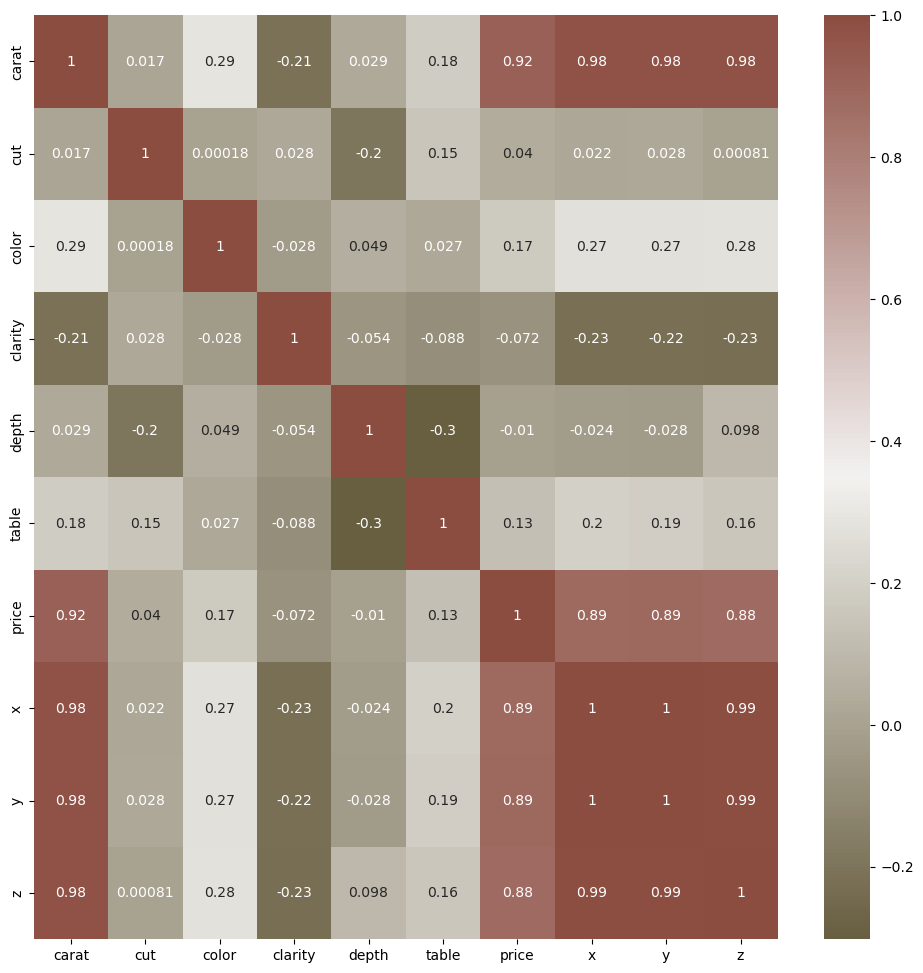

In [31]:
#correlation matrix
cmap = sns.diverging_palette(70,20,s=50, l=40, n=6,as_cmap=True)
corrmat= label_data.corr()
f, ax = plt.subplots(figsize=(12,12))
sns.heatmap(corrmat,cmap=cmap,annot=True, )

# Model Building and Comparaison

## Setting up features and target and data splitting

In [35]:
# Assigning the featurs as X and trarget as y
X= label_data.drop(["price"],axis =1)
y= label_data["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=7)

## Build a pipeline of standard scalar and model

In [37]:
# Building pipelins of standard scaler and model for varios regressors.

pipeline_lr=Pipeline([("scalar1",StandardScaler()),
                     ("lr_classifier",LinearRegression())])

pipeline_dt=Pipeline([("scalar2",StandardScaler()),
                     ("dt_classifier",DecisionTreeRegressor())])

pipeline_rf=Pipeline([("scalar3",StandardScaler()),
                     ("rf_classifier",RandomForestRegressor())])


# List of all the pipelines
pipelines = [pipeline_lr, pipeline_dt, pipeline_rf]

# Dictionary of pipelines and model types for ease of reference
pipe_dict = {0: "LinearRegression", 1: "DecisionTree", 2: "RandomForest"}

# Fit the pipelines
for pipe in pipelines:
    pipe.fit(X_train, y_train)


In [38]:
cv_results_rms = []
for i, model in enumerate(pipelines):
    cv_score = cross_val_score(model, X_train,y_train,scoring="neg_root_mean_squared_error", cv=10)
    cv_results_rms.append(cv_score)
    print("%s: %f " % (pipe_dict[i], cv_score.mean()))

LinearRegression: -1348.811824 
DecisionTree: -753.784599 
RandomForest: -547.828614 


## Testing the Model with the best score on the test set

#### In the above scores, RandomForest appears to be the model with the best scoring on negative root mean square error. Let's test this model on a test set and evaluate it with different parameters.

In [42]:
# Model prediction on test data
pred = pipeline_rf.predict(X_test)

In [43]:
# Model Evaluation
print("R^2:",metrics.r2_score(y_test, pred))
print("Adjusted R^2:",1 - (1-metrics.r2_score(y_test, pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print("MAE:",metrics.mean_absolute_error(y_test, pred))
print("MSE:",metrics.mean_squared_error(y_test, pred))
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test, pred)))

R^2: 0.9807286129842219
Adjusted R^2: 0.9807157339106983
MAE: 271.07393548090755
MSE: 302326.13282143243
RMSE: 549.8419162099525
